In [1]:
# !pip install markdown
# !pip install --upgrade kaleido

In [2]:
# --- Technical Setup ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import Dict, List, Optional, Tuple

# Ignore warnings for a cleaner executive report
warnings.filterwarnings('ignore')

# Set plotting style and display options
sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
print("✅ Setup complete.")

✅ Setup complete.


In [3]:
# --- Corrected Cell 1: Updated Imports ---

# Explicitly import all the necessary components from your consolidated .py file
from capacity_pipeline import (
    ColumnMap, ScoreConfig, WSIConfig, ScenarioConfig, OptimizeConfig,
    DataPrep, CapacityScorer, WSIComputer, OptimizeConfig, run_optimizer_pipeline, 
    pre_post_tree_pipeline, # NEW: The consolidated simulation function
    compute_capacity_centric_wsi, # NEW: The standalone WSI function
    make_sample_data,
    plot_score_distributions, plot_team_metrics, plot_feature_importances,
    plot_contributions_waterfall, plot_optimization_plan,
    plot_simulation_distributions, plot_bucket_uplift_distributions,
    plot_volume_uplift_distributions,
    pre_post_tree_pipeline_cap_cases
)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import Dict, List, Optional, Tuple

# Ignore warnings for a cleaner executive report
warnings.filterwarnings('ignore')

# Set plotting style and display options
sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
print("✅ Setup complete with all consolidated components imported.")

✅ Setup complete with all consolidated components imported.


In [4]:
# --- Fully Configurable Analysis Setup (Updated for Hybrid Approach) ---

# 1. IDENTIFIER COLUMNS (from your data)
cols = ColumnMap(
    date="_date_",
    alias="alias",
    group="StaffGroup",
    num_cases="TasksCompleted", # Map your 'TasksCompleted' to the pipeline's 'num_cases'
    backlog="BacklogSize",
    avg_dtc="AvgTimeToResolve",
    efficiency_raw="EfficiencyRating"
    # ... map any other relevant columns from your dataset
)

# 2. FEATURE COLUMNS (for Capacity Score)
my_feature_columns = [
    "TasksCompleted", "ActiveCases", "BacklogSize", "AvgTimeToResolve",
    "TenureInMonths", "EfficiencyRating", "CustomerSatisfaction"
]

my_feature_direction = {
    "TasksCompleted": False, "ActiveCases": True, "BacklogSize": True,
    "AvgTimeToResolve": True, "TenureInMonths": False, "EfficiencyRating": False,
    "CustomerSatisfaction": False
}

# 3. DERIVED METRIC NAMES (you can name these whatever you want)
CAPACITY_SCORE_COL = "Capacity_Score_0_100"
WSI_COL = "WSI_0_100"
EFFICIENCY_COL = "efficiency"
DTC_COL = "days_to_close"

# 4. CONFIGURATION OBJECTS

# --- NEW: Define weights for the features you want in the percentile score ---
# These keys should match the names in `my_feature_columns`.
feature_weights = {
    'TasksCompleted': 0.4,       # 40% of the score comes from case volume
    'EfficiencyRating': 0.3,   # 30% from efficiency
    'AvgTimeToResolve': 0.2,   # 20% from time to close
    'BacklogSize': 0.1         # 10% from backlog
}

# --- CHANGED: Updated ScoreConfig with guardrails ---
score_cfg = ScoreConfig(
    method="percentile",        # Use percentile for the final score
    direction_map=my_feature_direction, # Still needed for DataPrep
    random_state=42,
    # Guardrail 1: Set the final score floor to 20
    score_range=(20, 100),
    # Guardrail 2: Apply weights to the percentile calculation
    percentile_weights=feature_weights
)


wsi_cfg = WSIConfig(team_aggregate="mean")

scn_cfg = ScenarioConfig(capacity_col_out=CAPACITY_SCORE_COL, random_state=42)

opt_cfg = OptimizeConfig(
    budget_moves=15,
    objective_weights={
        WSI_COL: -1.0,
        EFFICIENCY_COL: +0.6,
        DTC_COL: -0.6,
        cols.backlog: -0.8,
        cols.num_cases: +0.25
    },
    random_state=42
)

# Define the targets for the OutcomeModeler dynamically
modeler_targets = (WSI_COL, EFFICIENCY_COL, DTC_COL, cols.backlog)

print("✅ Hybrid analysis setup with guardrails is ready.")

✅ Hybrid analysis setup with guardrails is ready.


In [5]:
# --- Configuration Settings ---

# Defines the column names in your data
cols = ColumnMap()

# List of features to use when calculating the Capacity Score
capacity_features = [
    "numCases", "numOpenCases", "backlog", "TimeSpent", "currentSevA",
    "Is24X7OptedIn", "IsClosedOnWeekend", "tenure", "som", "avgDaysToClose"
]

# Config for the Capacity Score
# In your notebook configuration cell

score_cfg = ScoreConfig(
    method="percentile",
    bench_percentile=0.70,
    scale_scope="by_group",
    percentile_clip=(5, 95),
    random_state=42,
    distribution="gaussian", # Use the new normalization method,
    score_range=(30, 100)

)

# Config for the Workload Stress Index (WSI)
# In your notebook configuration cell

wsi_cfg = WSIConfig(
    team_aggregate="mean",
    distribution="gaussian", # Use the new normalization method,
    feature_range=(20, 100),
    weights=dict(
        w_workload=0.50,
        cap_dev=0.10,
        persist=0.15,
        complexity=0.15,
        time=0.10
    )
)

# Config for "What-If" Scenarios
scn_cfg = ScenarioConfig(random_state=42)

# Config for the Optimizer
opt_cfg = OptimizeConfig(
    budget_moves=15,
    objective_weights=dict(
        WSI_0_100=-1.0,
        efficiency=+0.6,
        days_to_close=-0.6,
        backlog=-0.8,
        numCases=+0.25
    ),
    random_state=42
)

print("✅ Configuration loaded.")

✅ Configuration loaded.


In [6]:
# --- Corrected Cell 4: Load Data and Calculate Scores ---
#
# Here, we generate our sample monthly data and run the core pipeline to calculate the
# Capacity Score and Workload Stress Index (WSI) for every employee and team.

# 1. Generate sample data for three months
df_full = make_sample_data(n_groups=4, aliases_per_group=30, months=["2025-06", "2025-07", "2025-08"])
df_full['efficiency'] = df_full['som'] # Use coalesce_names logic
df_full['days_to_close'] = df_full['avgDaysToClose']

# 2. Prepare the data (calculate deviations from benchmark)
prep = DataPrep(columns=cols, features=capacity_features, config=score_cfg).fit(df_full)
df_prepped = prep.transform(df_full)

# 3. Calculate the 0-100 Capacity Score for each employee-month
scorer = CapacityScorer(config=score_cfg).fit(df_prepped, group_col=cols.group, id_cols=(cols.alias, cols.date))
scores = scorer.transform(df_prepped, group_col=cols.group, id_cols=(cols.alias, cols.date))

# FIX: Merge only the new score column to avoid creating duplicate 'StaffGroup_x/y' columns.
df_scored = df_full.merge(
    scores[[cols.alias, cols.date, 'Capacity_Score_0_100']],
    on=[cols.alias, cols.date],
    how="left"
)

# 4. Calculate the 0-100 WSI for each employee-month and aggregate for teams
wsi_computer = WSIComputer(columns=cols, config=wsi_cfg)
wsi_results = wsi_computer.compute(df_scored)
alias_metrics = wsi_results["alias_metrics"]
team_metrics = wsi_results["team_metrics"]

print("✅ All scores calculated successfully.")
display(alias_metrics.head())

✅ All scores calculated successfully.


,alias,StaffGroup,_date_,Capacity_Score_0_100,WSI_0_100,cap_dev,complexity
0,SG-A-E01,SG-A,2025-06-01,62.04,51.01,0.00,0.06
1,SG-A-E01,SG-A,2025-07-01,58.98,48.38,0.00,0.07
2,SG-A-E01,SG-A,2025-08-01,53.05,42.15,0.00,0.06
3,SG-A-E02,SG-A,2025-06-01,56.40,63.19,0.00,0.09
4,SG-A-E02,SG-A,2025-07-01,47.97,51.92,0.00,0.04


--- How are our employees distributed across these scores? (Latest Month) ---
✅ Plot saved to: score_distributions.png


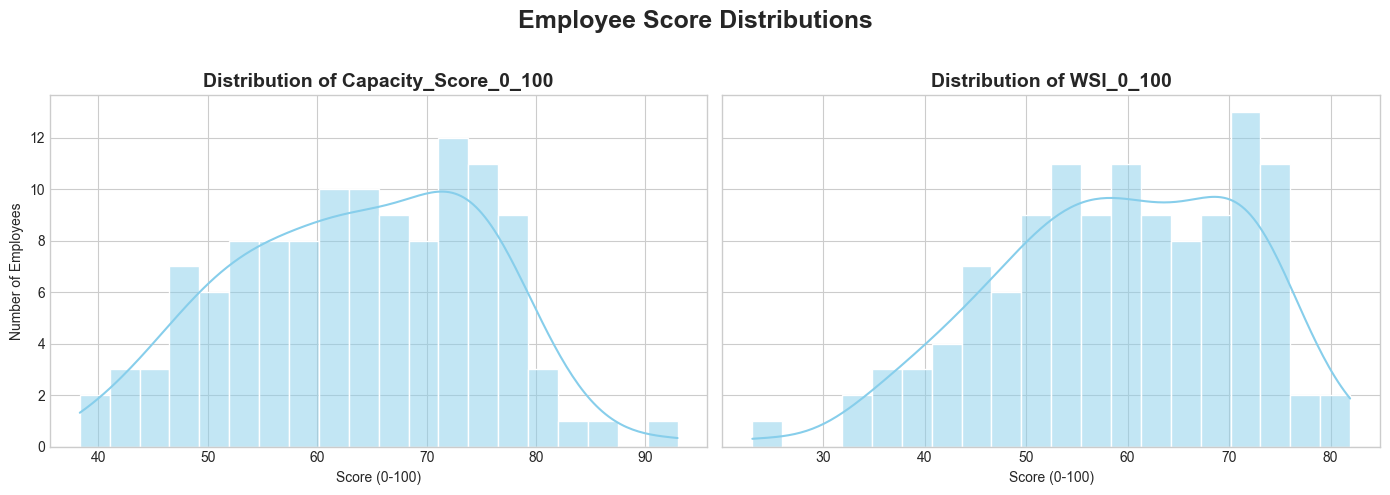


--- How do the teams compare on key WSI components over time? ---
Note: 'Capacity Deviation' now shows positive (above baseline) and negative (below baseline) performance.
✅ Plot saved to: team_metrics_over_time.png


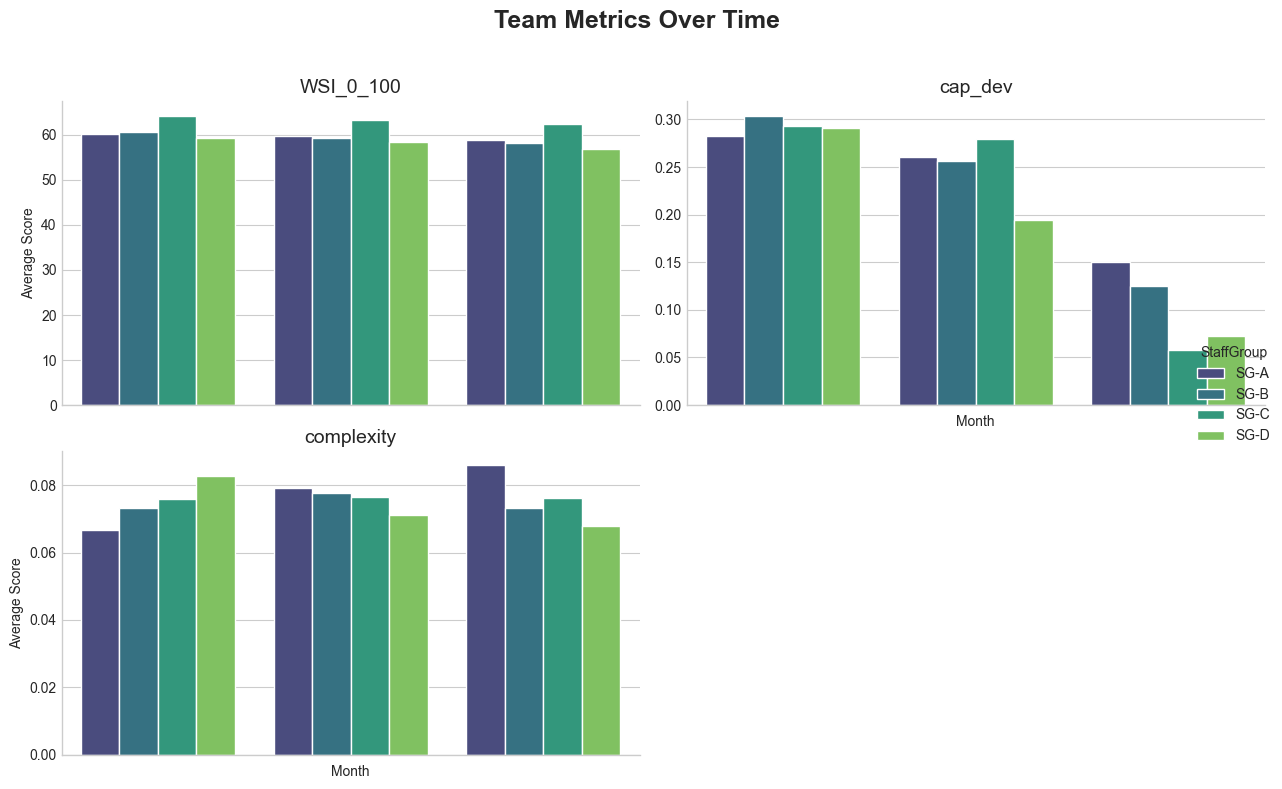

In [7]:
# --- Corrected Cell 5: ❓ Question 1: What are the Capacity Score & WSI? ---

# The Capacity Score (0-100) measures an employee's overall operational performance. A higher score is better.
# The Workload Stress Index (WSI) (0-100) measures workload pressure. A higher score indicates more stress.

# This dictionary will store the paths to all our saved plots.
saved_plots = {}

print("--- How are our employees distributed across these scores? (Latest Month) ---")
latest_month_df = alias_metrics[alias_metrics['_date_'] == alias_metrics['_date_'].max()]

# Define a path and save the plot
score_dist_path = "score_distributions.png"
plot_score_distributions(latest_month_df, ['Capacity_Score_0_100', 'WSI_0_100'], save_path=score_dist_path)
saved_plots["[INSERT SCORE DISTRIBUTION PLOT HERE]"] = score_dist_path


print("\n--- How do the teams compare on key WSI components over time? ---")
print("Note: 'Capacity Deviation' now shows positive (above baseline) and negative (below baseline) performance.")

# Define a path and save the plot
team_metrics_path = "team_metrics_over_time.png"
plot_team_metrics(team_metrics, ['WSI_0_100', 'cap_dev', 'complexity'], save_path=team_metrics_path)
saved_plots["[INSERT TEAM METRICS PLOT HERE]"] = team_metrics_path

--- Global Drivers: What factors matter most across the organization? ---
✅ Plot saved to: feature_importance.png


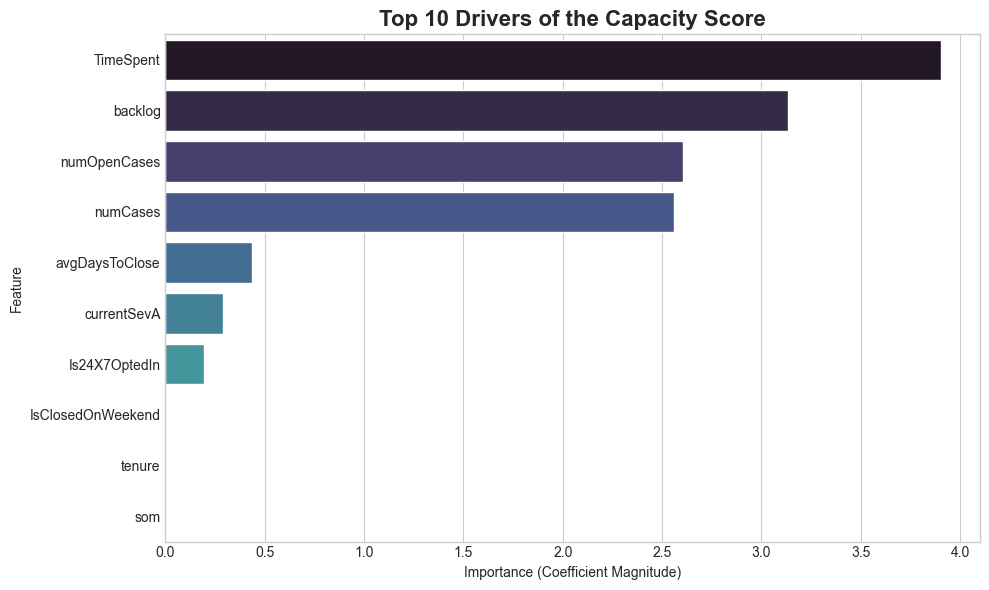


--- Local Drivers: Why did a specific employee get their score? ---
✅ Plot saved to: contributions_waterfall.png


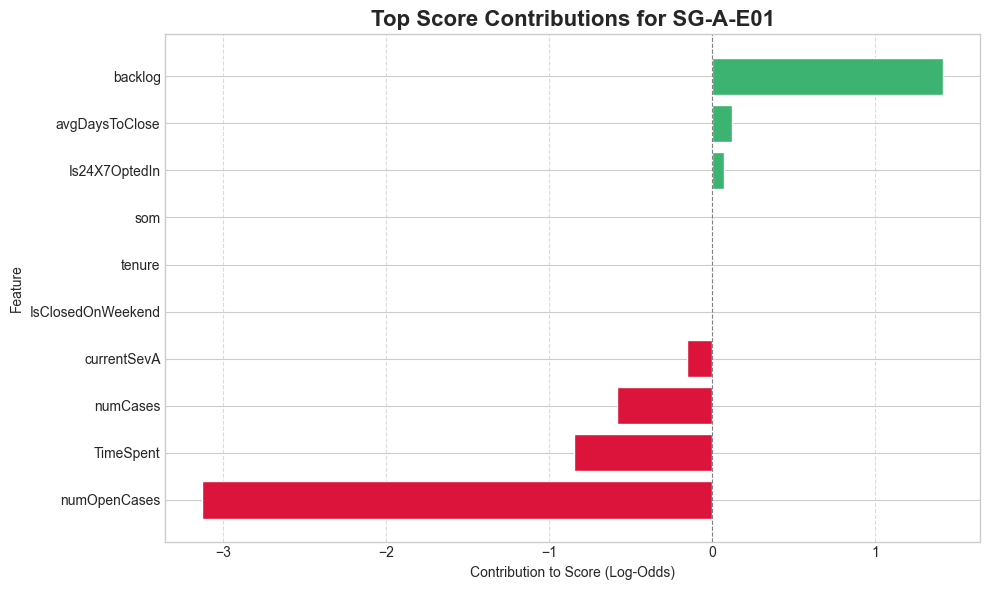

In [8]:
# print("--- Global Drivers: What factors matter most across the organization? ---")
# # This chart shows the factors with the highest overall impact on the Capacity Score.
# # A higher bar means the feature is more influential in determining the score.
# plot_feature_importances(scorer)

# print("\n--- Local Drivers: Why did a specific employee get their score? ---")
# # This waterfall chart breaks down the score for a single employee.
# # Green bars are factors that helped their score; red bars are factors that hurt it.
# example_employee = df_prepped.iloc[0]
# contributions = scorer.contributions(df_prepped, alias=example_employee[cols.alias], date=example_employee[cols.date])
# plot_contributions_waterfall(contributions, alias=example_employee[cols.alias])


# In Cell [7]
print("--- Global Drivers: What factors matter most across the organization? ---")
feature_importance_path = "feature_importance.png" # Define path
plot_feature_importances(scorer, save_path=feature_importance_path) # Add save_path

print("\n--- Local Drivers: Why did a specific employee get their score? ---")
example_employee = df_prepped.iloc[0]
contributions = scorer.contributions(df_prepped, alias=example_employee[cols.alias], date=example_employee[cols.date])
contributions_path = "contributions_waterfall.png" # Define path
plot_contributions_waterfall(contributions, alias=example_employee[cols.alias], save_path=contributions_path) # Add save_path

In [9]:
# # --- Corrected Cell 7: ❓ Question 3: What-If Scenario - Simulating Headcount Moves ---
# print("This tool simulates moving employees between teams to see the projected impact.")

# # Define your hypothetical moves
# moves = [
#     {"from": "SG-A", "to": "SG-C", "n": 30}
# ]

# # Run the simulation
# df_month = df_full[df_full['_date_'] == df_full['_date_'].max()]
# modeler = OutcomeModeler().fit(alias_metrics.dropna())
# engine = ScenarioEngine(columns=cols, prep=prep, scorer=scorer, wsi=wsi_computer, modeler=modeler, config=scn_cfg)
# sim_results = engine.simulate_moves(df_month, moves=moves)

# print("\n--- Simulation Results: Comparing 'Before' vs. 'After' ---")
# # This heatmap visualizes the projected state of each team before and after the move.
# # The color is based on the WSI score (Green = Low Stress, Red = High Stress).
# simulation_heatmap_path = "simulation_heatmap.png"

# # FIX: Use the correct keys "pre_agg" and "post_agg" to access the dataframes
# stacked_sim_data = plot_simulation_heatmap(
#     sim_results["pre_agg"], 
#     sim_results["post_agg"], 
#     only_impacted=False,  # This is the default, but we're being explicit
#     save_path="simulation_heatmap_impacted.png"
# )
# saved_plots["[INSERT SIMULATION HEATMAP HERE]"] = simulation_heatmap_path

# # NEW: Overlapping distribution plots for key metrics at the employee level
# simulation_dist_path = "simulation_distributions.png"
# plot_simulation_distributions(
#     pre_df_employee=sim_results["pre_employee"],
#     post_df_employee=sim_results["post_employee"],
#     metrics=['Capacity_Score_0_100', 'WSI_0_100', 'efficiency'],
#     save_path=simulation_dist_path
# )
# saved_plots["[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]"] = simulation_dist_path


# print("\n✅ Simulation plots saved successfully.")

In [10]:
# --- Corrected Cell 7: Consolidated "What-If" Scenario ---
print("This tool simulates moving employees between teams to see the projected impact.")

# 1. Define your hypothetical moves
moves = [
    {"from": "SG-A", "to": "SG-C", "n": 5}
]

# 2. Build the baseline scores dataframe needed for the pipeline
scores_baseline = scores[[cols.date, cols.alias, "Capacity_Score_0_100"]].dropna().copy()

# 3. Define the WSI calculation parameters
wsi_kwargs = dict(
    date_col="_date_",
    alias_col="alias",
    sg_col="StaffGroup",
    cap_col="Capacity_Score_0_100",
    cases_col="numCases",
    complexity_col="complexity",
    linearity_col="LinearityScore",
    sev_cols=("currentSev1", "currentSevA", "currentSevB"),
    weekend_col="IsClosedOnWeekend",
    x24_col="Is24X7OptedIn",
    baseline_window_months=12,
    persist_window_months=8,
    high_cap_thresh=75.0,
    w_workload=0.30,
    w_cap_dev=0.30,
    w_persist=0.15,
    w_complex=0.15,
    w_time=0.10,
    q_low=0.05,
    q_high=0.95,
    team_aggregate="median",
    distribution="gaussian",
    feature_range=(10, 100)
)

# --- NEW: Define the outcome metrics to predict ---
modeler_targets = ("WSI_0_100", "efficiency", "days_to_close", "backlog")


# 4. Run the consolidated simulation pipeline
grid_pre, grid_post, combined, fig, mse_report, sanity_df = pre_post_tree_pipeline(
    df_in=df_full,
    scores_baseline=scores_baseline,
    month=df_full["_date_"].max().strftime("%Y-%m"),
    moves=moves,
    compute_wsi_fn=compute_capacity_centric_wsi,
    wsi_kwargs=wsi_kwargs,
    targets=modeler_targets,
    only_impacted=True,
    team_level_post=True     # <--- NEW
)

# 6. Display the results
print("\n--- Sanity Check: Typical Metric Ranges (based on pre-move data) ---")
display(sanity_df)

print("\n--- Simulation Results: Comparing 'Before' vs. 'After' ---")
fig.show()

print("\n--- Detailed Dataframes ---")
display(combined)

# --- ADD THIS TO SAVE THE PLOT ---
# Define a path for the simulation heatmap
simulation_heatmap_path = "simulation_heatmap.png"

# Save the Plotly figure as a static image
# You may need to run: pip install -U kaleido
fig.write_image(simulation_heatmap_path)

print(f"✅ Simulation heatmap saved to: {simulation_heatmap_path}")

This tool simulates moving employees between teams to see the projected impact.

[DEBUG] Team-level predict() sample (first 20 rows):
 Capacity StaffGroup
    72.14       SG-A
    57.03       SG-B
    58.53       SG-C
    62.49       SG-D
Rows to predict (team-level): 4

--- Sanity Check: Typical Metric Ranges (based on pre-move data) ---


,Typical Range (25th-75th percentile)
Metric,
Capacity,55.05 to 72.75
WSI_0_100,44.72 to 61.61
efficiency,0.76 to 0.86
days_to_close,5.38 to 8.71
backlog,15.75 to 24.00



--- Simulation Results: Comparing 'Before' vs. 'After' ---



--- Detailed Dataframes ---


,StaffGroup,Capacity,WSI_0_100,efficiency,days_to_close,backlog,Scenario
0,SG-A,72.14,55.19,0.80,7.40,24.04,Post (pred)
1,SG-A,69.20,55.00,0.78,7.22,19.50,Pre
2,SG-C,58.53,57.60,0.81,6.99,23.71,Post (pred)
3,SG-C,64.02,56.47,0.82,6.89,18.50,Pre


✅ Simulation heatmap saved to: simulation_heatmap.png


In [11]:
# --- Corrected Cell 7: Consolidated "What-If" Scenario ---
print("This tool simulates moving employees between teams to see the projected impact.")

# 1. Define your hypothetical moves
moves = [
    {"from": "SG-A", "to": "SG-C", "n": 5}
]

# 2. Build the baseline scores dataframe needed for the pipeline
scores_baseline = scores[[cols.date, cols.alias, "Capacity_Score_0_100"]].dropna().copy()

# 3. Define the WSI calculation parameters
wsi_kwargs = dict(
    date_col="_date_",
    alias_col="alias",
    sg_col="StaffGroup",
    cap_col="Capacity_Score_0_100",
    cases_col="numCases",
    complexity_col="complexity",
    linearity_col="LinearityScore",
    sev_cols=("currentSev1", "currentSevA", "currentSevB"),
    weekend_col="IsClosedOnWeekend",
    x24_col="Is24X7OptedIn",
    baseline_window_months=12,
    persist_window_months=8,
    high_cap_thresh=75.0,
    w_workload=0.30,
    w_cap_dev=0.30,
    w_persist=0.15,
    w_complex=0.15,
    w_time=0.10,
    q_low=0.05,
    q_high=0.95,
    team_aggregate="median",
    distribution="gaussian",
    feature_range=(10, 100)
)

# --- NEW: Define the outcome metrics to predict ---
modeler_targets = ("WSI_0_100", "efficiency", "days_to_close", "backlog")


# 4. Run the consolidated simulation pipeline
grid_pre, grid_post, combined, fig, mse_report, sanity_df = pre_post_tree_pipeline_cap_cases(
    df_in=df_full,
    scores_baseline=scores_baseline,
    month=df_full["_date_"].max().strftime("%Y-%m"),
    moves=moves,
    compute_wsi_fn=compute_capacity_centric_wsi,
    wsi_kwargs=wsi_kwargs,
    targets=("WSI_0_100","efficiency","days_to_close","backlog"),
    only_impacted=True,
    team_level_post=False,     # alias-level by default (median to team)
    show_predict_samples=True  # see the exact X used by .predict()
)

# 6. Display the results
print("\n--- Sanity Check: Typical Metric Ranges (based on pre-move data) ---")
display(sanity_df)

print("\n--- Simulation Results: Comparing 'Before' vs. 'After' ---")
fig.show()

print("\n--- Detailed Dataframes ---")
display(combined)

# --- ADD THIS TO SAVE THE PLOT ---
# Define a path for the simulation heatmap
simulation_heatmap_path = "simulation_heatmap.png"

# Save the Plotly figure as a static image
# You may need to run: pip install -U kaleido
fig.write_image(simulation_heatmap_path)

print(f"✅ Simulation heatmap saved to: {simulation_heatmap_path}")

This tool simulates moving employees between teams to see the projected impact.
[WARN] simulate_post_capacity did not provide 'numCases'; using PRE team medians as a fallback.

[DEBUG] Alias-level POST predict() input (first 12 rows):
 Capacity  numCases StaffGroup
    72.14     41.00       SG-A
    57.03     42.50       SG-B
    58.53     44.50       SG-C
    62.49     41.00       SG-D
Rows to predict (alias-level): 4

--- Sanity Check: Typical Metric Ranges (based on pre-move data) ---


,Typical Range (25th-75th percentile)
Metric,
Capacity,55.05 to 72.75
numCases,36.75 to 50.00
WSI_0_100,44.72 to 61.61
efficiency,0.76 to 0.86
days_to_close,5.38 to 8.71
backlog,15.75 to 24.00



--- Simulation Results: Comparing 'Before' vs. 'After' ---



--- Detailed Dataframes ---


,StaffGroup,Capacity,numCases,WSI_0_100,efficiency,days_to_close,backlog,Scenario
0,SG-A,72.14,41.00,61.58,0.74,9.41,27.86,Post (pred)
1,SG-A,69.20,41.00,55.00,0.78,7.22,19.50,Pre
2,SG-C,58.53,44.50,51.34,0.87,4.77,17.77,Post (pred)
3,SG-C,64.02,44.50,56.47,0.82,6.89,18.50,Pre


✅ Simulation heatmap saved to: simulation_heatmap.png


This analysis simulates the impact of improving employee capacity by moving staff between performance buckets.
Running with flexible move plan:
- Moving 1 employees from bucket '25-50' to '75-100'
- Moving 12 employees from bucket '50-75' to '75-100'

--- Bucket Uplift Summary ---


,bucket,aliases,nc_median,pct,moved_in,new_cases_bucket,original_cases_handled,net_incremental_cases
0,0-25,0,NaN,0.00,0,0.00,0.00,0.00
1,25-50,16,36.00,13.33,0,0.00,0.00,0.00
2,50-75,84,41.50,70.00,0,0.00,0.00,0.00
3,75-100,20,59.50,16.67,13,773.50,534.00,239.50
4,TOTAL,120,NaN,100.00,13,773.50,534.00,239.50


✅ Volume uplift plot saved to: total_volume_uplift_distribution.png


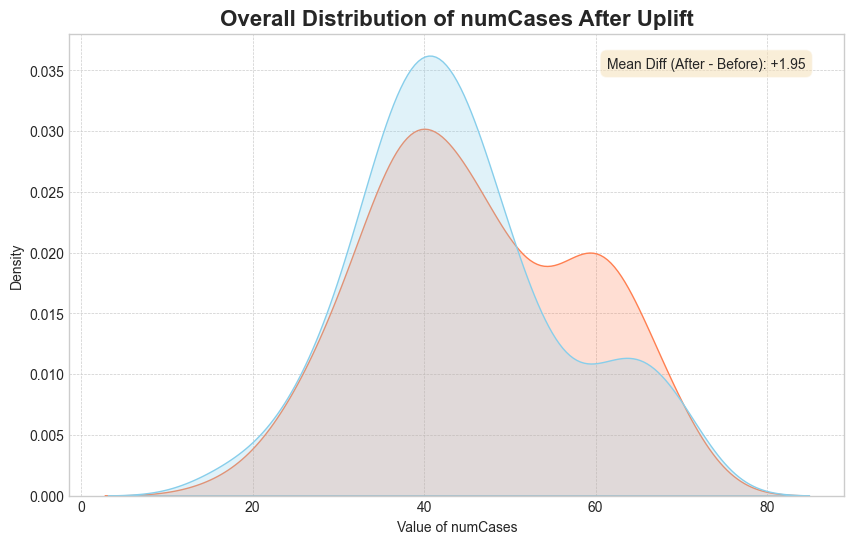


--- Sanity Check Calculation ---
Total 'numCases' Before Simulation: 5,282.00
Total 'numCases' After Simulation:  5,515.50
Total Simulated Uplift:             233.50


In [12]:
# --- Corrected Cell: 📈 Consolidated & Flexible Bucket Uplift Analysis ---

import numpy as np
import pandas as pd
from typing import List, Dict

print("This analysis simulates the impact of improving employee capacity by moving staff between performance buckets.")

def run_bucket_uplift_analysis(
    alias_metrics_df: pd.DataFrame,
    cap_edges: List[float] = [0, 25, 50, 75, 100],
    moves: List[Dict] = None
):
    """
    Performs a flexible uplift analysis, returning both an aggregate summary
    and the detailed 'before' and 'after' dataframes for plotting.
    """
    if moves is None:
        moves = []

    df = alias_metrics_df.copy()
    cap_labels = [f"{int(cap_edges[i])}-{int(cap_edges[i+1])}" for i in range(len(cap_edges)-1)]

    # 1. Assign employees to initial capacity buckets
    df["bucket"] = pd.cut(df['Capacity_Score_0_100'], bins=cap_edges, labels=cap_labels, include_lowest=True)

    # 2. Create the 'before' and 'after' dataframes for simulation
    pre_volume_df = df.copy()
    post_volume_df = df.copy()

    # 3. Get initial stats for the summary table
    stats = df.groupby("bucket", observed=False).agg(
        aliases=("alias", "nunique"),
        nc_median=("numCases", "median")
    ).reindex(cap_labels).reset_index()

    # 4. Run the simulation
    print("Running with flexible move plan:")
    for move in moves:
        source_idx, dest_idx, pct = move.get('from'), move.get('to'), move.get('pct')
        if any(v is None for v in [source_idx, dest_idx, pct]) or not (0 <= source_idx < len(stats) and 0 <= dest_idx < len(stats)):
            continue

        aliases_to_move_from = df[df['bucket'] == cap_labels[source_idx]]['alias'].unique()
        n_to_move = int(np.floor(len(aliases_to_move_from) * pct))

        if n_to_move > 0:
            print(f"- Moving {n_to_move} employees from bucket '{cap_labels[source_idx]}' to '{cap_labels[dest_idx]}'")
            moved_aliases = np.random.choice(aliases_to_move_from, size=n_to_move, replace=False)
            
            # Update the 'numCases' in the post-simulation dataframe
            target_median = stats.loc[dest_idx, "nc_median"]
            if pd.notna(target_median):
                post_volume_df.loc[post_volume_df['alias'].isin(moved_aliases), 'numCases'] = target_median

    # 5. Generate the summary table based on the simulation plan
    summary_stats = stats.copy()
    summary_stats["moved_in"], summary_stats["new_cases_bucket"], summary_stats["original_cases_handled"] = 0, 0.0, 0.0

    for move in moves:
        source_idx, dest_idx, pct = move.get('from'), move.get('to'), move.get('pct')
        if any(v is None for v in [source_idx, dest_idx, pct]) or not (0 <= source_idx < len(summary_stats) and 0 <= dest_idx < len(summary_stats)):
            continue
        
        num_moving = int(np.floor(summary_stats.loc[source_idx, "aliases"] * pct))
        if num_moving > 0:
            summary_stats.loc[dest_idx, "moved_in"] += num_moving
            summary_stats.loc[dest_idx, "original_cases_handled"] += num_moving * summary_stats.loc[source_idx, "nc_median"]
            summary_stats.loc[dest_idx, "new_cases_bucket"] += num_moving * summary_stats.loc[dest_idx, "nc_median"]

    summary_stats["net_incremental_cases"] = summary_stats["new_cases_bucket"] - summary_stats["original_cases_handled"]
    summary_stats["pct"] = (summary_stats["aliases"] / max(1, summary_stats["aliases"].sum()) * 100).round(2)
    
    total_row = pd.DataFrame([{
        "bucket": "TOTAL", "aliases": int(summary_stats["aliases"].sum()), "pct": 100.0,
        "moved_in": int(summary_stats["moved_in"].sum()),
        "new_cases_bucket": float(summary_stats["new_cases_bucket"].sum()),
        "original_cases_handled": float(summary_stats["original_cases_handled"].sum()),
        "net_incremental_cases": float(summary_stats["net_incremental_cases"].sum())
    }])
    
    display_cols = ["bucket", "aliases", "nc_median", "pct", "moved_in", "new_cases_bucket", "original_cases_handled", "net_incremental_cases"]
    summary_df = pd.concat([summary_stats, total_row], ignore_index=True)[display_cols]
    
    return summary_df, pre_volume_df, post_volume_df

# --- Run the Analysis ---
uplift_input_df = df_scored[df_scored['_date_'] == df_scored['_date_'].max()].merge(
    alias_metrics[['_date_', 'alias', 'WSI_0_100']], on=['_date_', 'alias']
)

# Define your flexible moves
flexible_moves = [
    {"from": 0, "to": 2, "pct": 0.15},
    {"from": 1, "to": 3, "pct": 0.10},
    {"from": 2, "to": 3, "pct": 0.15},
    {"from": 0, "to": 3, "pct": 0.15}
]

# A single function call now provides all three results
bucket_uplift_summary, pre_volume_df, post_volume_df = run_bucket_uplift_analysis(
    uplift_input_df,
    moves=flexible_moves
)

# --- Display the Summary Table ---
print("\n--- Bucket Uplift Summary ---")
display(bucket_uplift_summary)

# --- Plot the Distribution ---
volume_dist_path = "total_volume_uplift_distribution.png"
plot_volume_uplift_distributions(
    pre_df=pre_volume_df,
    post_df=post_volume_df,
    metric='numCases',
    save_path=volume_dist_path
)
saved_plots["[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]"] = volume_dist_path

# --- Run the Sanity Check ---
sum_before = pre_volume_df['numCases'].sum()
sum_after = post_volume_df['numCases'].sum()
simulated_uplift = sum_after - post_volume_df['numCases'][post_volume_df['alias'].isin(pre_volume_df['alias']) == False].sum()


print(f"\n--- Sanity Check Calculation ---")
print(f"Total 'numCases' Before Simulation: {sum_before:,.2f}")
print(f"Total 'numCases' After Simulation:  {sum_after:,.2f}")
print(f"Total Simulated Uplift:             {sum_after - sum_before:,.2f}")



This analysis segments employees into four performance categories based on their Capacity and WSI scores.

--- Quadrant Analysis for ALL Groups ---
✅ Plot saved to: quadrant_all_groups.png


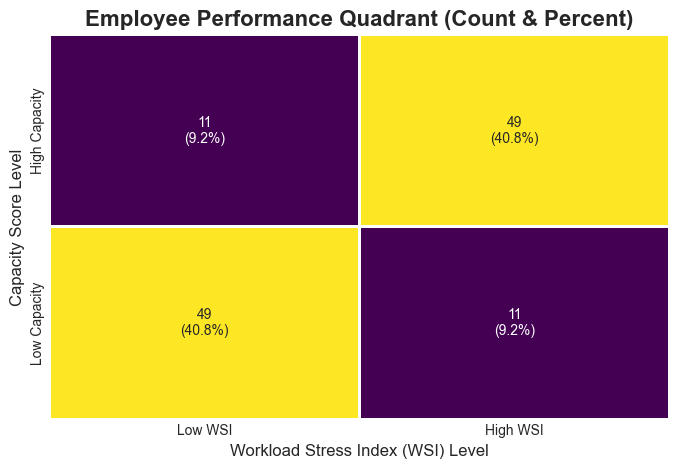

WSI Level,Low WSI,High WSI
Capacity Level,,
High Capacity,11\n(9.2%),49\n(40.8%)
Low Capacity,49\n(40.8%),11\n(9.2%)



--- Quadrant Analysis for SG-A and SG-C Only ---
✅ Plot saved to: quadrant_filtered_groups.png


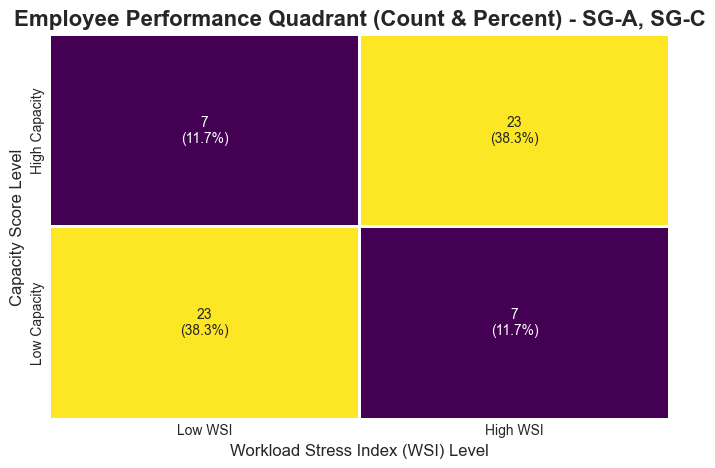

WSI Level,Low WSI,High WSI
Capacity Level,,
High Capacity,7\n(11.7%),23\n(38.3%)
Low Capacity,23\n(38.3%),7\n(11.7%)


In [13]:
# --- 📊 2x2 Performance Quadrant Analysis (Now saves the plots) ---
print("This analysis segments employees into four performance categories based on their Capacity and WSI scores.")

def create_performance_quadrant(alias_metrics_df, group_filter=None, save_path: Optional[str] = None):
    df = alias_metrics_df.copy()
    if group_filter:
        df = df[df['StaffGroup'].isin(group_filter)]

    if df.empty:
        print("No data for the selected filter.")
        return pd.DataFrame(), None # Return None for the path

    cap_median = df['Capacity_Score_0_100'].median()
    wsi_median = df['WSI_0_100'].median()

    # Create separate columns for the 2x2 grid
    df['Capacity Level'] = np.where(df['Capacity_Score_0_100'] >= cap_median, 'High Capacity', 'Low Capacity')
    df['WSI Level'] = np.where(df['WSI_0_100'] >= wsi_median, 'High WSI', 'Low WSI')

    # Create the 2x2 grid of counts and percentages
    count_table = pd.crosstab(df['Capacity Level'], df['WSI Level'])
    if 'Low WSI' in count_table.columns:
        count_table = count_table[['Low WSI', 'High WSI']]
    percent_table = (count_table / len(df) * 100).round(1)
    annot_table = count_table.astype(str) + "\n(" + percent_table.astype(str) + "%)"

    # Visualization: Heatmap of the 2x2 Grid
    plt.figure(figsize=(8, 5))
    sns.heatmap(
        count_table,
        annot=annot_table,
        fmt='s',
        cmap="viridis",
        cbar=False,
        linewidths=2,
        linecolor='white'
    )
    title = 'Employee Performance Quadrant (Count & Percent)'
    if group_filter:
        title += f" - {', '.join(group_filter)}"
    plt.title(title, fontsize=16, weight='bold')
    plt.ylabel('Capacity Score Level', fontsize=12)
    plt.xlabel('Workload Stress Index (WSI) Level', fontsize=12)
    
    # --- ADDED SAVE LOGIC ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"✅ Plot saved to: {save_path}")

    plt.show()

    # Return the formatted table and the path to the saved image
    return annot_table, save_path

# --- Run the Analysis for ALL Groups ---
print("\n--- Quadrant Analysis for ALL Groups ---")
quadrant_all_path = "quadrant_all_groups.png"
wsi_capacity_quadrant_all, path1 = create_performance_quadrant(latest_month_df, save_path=quadrant_all_path)
if path1:
    saved_plots["[INSERT QUADRANT PLOT ALL GROUPS HERE]"] = path1
display(wsi_capacity_quadrant_all)


# --- Run for a specific subset of groups ---
print("\n--- Quadrant Analysis for SG-A and SG-C Only ---")
quadrant_filtered_path = "quadrant_filtered_groups.png"
wsi_capacity_quadrant_filtered, path2 = create_performance_quadrant(latest_month_df, group_filter=['SG-A', 'SG-C'], save_path=quadrant_filtered_path)
if path2:
    saved_plots["[INSERT QUADRANT PLOT FILTERED HERE]"] = path2
display(wsi_capacity_quadrant_filtered)




In [14]:
# --- ❓ Question 4: What is the optimal headcount distribution? ---

print("This tool runs an optimization algorithm to find a set of employee moves")
print("that best achieves our defined business goals (e.g., reducing WSI and backlog).")

# --- 1) Define Business Goals for Optimization ---
opt_cfg = OptimizeConfig(
    budget_moves=15,
    objective_weights={
        WSI_COL: -1.0,
        EFFICIENCY_COL: +0.6,
        DTC_COL: -0.6,
        "backlog": -0.8,   # canonical name expected by the grids
        "numCases": +0.25  # canonical name expected by the grids
    },
    random_state=42
)

# --- 2) Run the Full Optimizer Pipeline ---
plan_output = run_optimizer_pipeline(
    df_full=df_full,
    scores_baseline=scores,
    opt_cfg=opt_cfg,
    cols=cols,
    compute_wsi_fn=compute_capacity_centric_wsi,
    wsi_kwargs=wsi_kwargs,
    targets=modeler_targets,
    only_impacted=False  # important so the first step evaluates all teams
)

# --- 3) Display the Results ---
print("\n--- Recommended Reassignment Plan (Net Moves) ---")

plan_list = plan_output.get("plan", [])
if not plan_list:
    print("No improving moves found within the budget and objective; the optimizer returned an empty plan.")
else:
    plan_df = pd.DataFrame(plan_list)

    # Normalize column names for the plotting helper
    if {"from", "to"}.issubset(plan_df.columns):
        plan_for_plot = plan_df.rename(columns={"from": "from_group", "to": "to_group"})
    elif {"from_group", "to_group"}.issubset(plan_df.columns):
        plan_for_plot = plan_df.copy()
    else:
        display(plan_df.head())
        raise ValueError("Expected ['from','to','n'] or ['from_group','to_group','n'].")

    # Summary table
    plan_summary = (
        plan_for_plot
        .groupby(["from_group", "to_group"])
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
    )
    display(plan_summary)

    # Plot and stash
    optimizer_plan_path = "optimizer_plan.png"
    plot_optimization_plan(plan_for_plot.to_dict("records"), save_path=optimizer_plan_path)
    if "saved_plots" not in globals():
        saved_plots = {}
    saved_plots["[INSERT OPTIMIZER PLAN PLOT HERE]"] = optimizer_plan_path

print("\n--- Projected Metrics: Initial vs. Optimized State ---")
comparison = plan_output["initial_metrics"].merge(
    plan_output["expected_metrics"],
    on="StaffGroup",
    suffixes=("_Initial", "_Optimized")
)
display(comparison)

This tool runs an optimization algorithm to find a set of employee moves
that best achieves our defined business goals (e.g., reducing WSI and backlog).

[DEBUG] Alias-level predict() sample (first 8 rows):
 Capacity StaffGroup
    66.00       SG-A
    57.03       SG-B
    59.97       SG-C
    62.49       SG-D
Rows to predict (alias-level): 4

[DEBUG] Alias-level predict() sample (first 8 rows):
 Capacity StaffGroup
    66.00       SG-A
    57.03       SG-B
    59.97       SG-C
    62.49       SG-D
Rows to predict (alias-level): 4

[DEBUG] Alias-level predict() sample (first 8 rows):
 Capacity StaffGroup
    66.00       SG-A
    57.03       SG-B
    67.89       SG-C
    62.49       SG-D
Rows to predict (alias-level): 4

[DEBUG] Alias-level predict() sample (first 8 rows):
 Capacity StaffGroup
    66.00       SG-A
    57.03       SG-B
    67.89       SG-C
    62.49       SG-D
Rows to predict (alias-level): 4

[DEBUG] Alias-level predict() sample (first 8 rows):
 Capacity StaffGroup
    

,StaffGroup,Capacity_Initial,WSI_0_100_Initial,efficiency_Initial,days_to_close_Initial,backlog_Initial,Capacity_Optimized,WSI_0_100_Optimized,efficiency_Optimized,days_to_close_Optimized,backlog_Optimized
0,SG-A,69.20,55.00,0.78,7.22,19.50,66.00,55.19,0.80,7.40,24.04
1,SG-B,65.08,53.53,0.83,7.28,18.00,57.03,55.24,0.81,6.98,21.96
2,SG-C,64.02,56.47,0.82,6.89,18.50,59.97,57.60,0.81,6.99,23.71
3,SG-D,62.34,51.77,0.77,7.87,20.00,62.49,52.47,0.78,8.12,23.43


In [19]:
import pandas as pd

def _md(obj, *, index=False, default="(no data)"):
    """
    Robustly convert obj to markdown text.
    Handles DataFrame, Series, dict, list of dicts/tuples, strings, None.
    """
    try:
        if obj is None:
            return default
        if isinstance(obj, pd.DataFrame):
            if obj.empty:
                return default
            return obj.to_markdown(index=index)
        if isinstance(obj, pd.Series):
            if obj.empty:
                return default
            return obj.to_frame(name=obj.name or "value").to_markdown(index=index)
        if isinstance(obj, dict):
            if not obj:
                return default
            df = pd.DataFrame(list(obj.items()), columns=["key", "value"])
            return df.to_markdown(index=False)
        if isinstance(obj, (list, tuple)):
            if not obj:
                return default
            # list of dicts → DataFrame
            if all(isinstance(x, dict) for x in obj):
                df = pd.DataFrame(obj)
                if df.empty:
                    return default
                return df.to_markdown(index=index)
            # list/tuple of tuples → DataFrame
            if all(isinstance(x, (list, tuple)) for x in obj):
                df = pd.DataFrame(obj)
                if df.empty:
                    return default
                return df.to_markdown(index=index)
            # otherwise dump as Series
            return pd.Series(obj).to_frame("value").to_markdown(index=index)
        # string / other
        s = str(obj).strip()
        return s if s else default
    except Exception as e:
        return f"(render error: {e})"

def _feature_importances_md(scorer_obj):
    """
    Try to render feature importances; return a friendly note if unavailable.
    """
    try:
        fi = scorer_obj.feature_importances()
        if isinstance(fi, pd.DataFrame) and not fi.empty:
            return fi.to_markdown(index=False)
        return "(feature importances not available)"
    except Exception:
        return "(feature importances not available for this scoring method)"

def _weights_md(weights_like, first="Component", second="Weight"):
    if hasattr(weights_like, "items"):
        df = pd.DataFrame(list(weights_like.items()), columns=[first, second])
        return _md(df, index=False)
    return _md(weights_like)

def generate_llm_text_prompt(
    team_metrics_df,
    scorer_obj,
    simulation_df,         # 'combined' dataframe (pre/post stacked)
    sanity_df,
    mse_report_df,
    contributions_df,
    opt_plan_obj,
    bucket_uplift_df,
    quadrant_df,
    filtered_quadrant_df,
    wsi_config,
    opt_config,
    post_volume_df
):
    """
    Compiles a comprehensive, text-only prompt using robust markdown conversion.
    """

    # --- Robust markdown conversions ---
    team_metrics_md      = _md(team_metrics_df, index=False)
    feature_importance_md= _feature_importances_md(scorer_obj)
    simulation_md        = _md(simulation_df, index=False)
    # opt plan bits may be dicts or DFs
    opt_plan_md          = _md(getattr(pd, "DataFrame")(opt_plan_obj.get("plan", [])), index=False)
    opt_expected_md      = _md(opt_plan_obj.get("expected_metrics"), index=False)
    bucket_uplift_md     = _md(bucket_uplift_df, index=False)
    quadrant_md          = _md(quadrant_df)
    filtered_quadrant_md = _md(filtered_quadrant_df)
    wsi_weights_md       = _weights_md(getattr(wsi_config, "weights", {}), first="Component", second="Weight")
    opt_weights_md       = _weights_md(getattr(opt_config, "objective_weights", {}), first="Metric", second="Weight")
    # post volume stats
    try:
        post_volume_md = _md(post_volume_df[["numCases"]].describe())
    except Exception:
        post_volume_md = _md(post_volume_df)

    # Extra frames
    sanity_md            = _md(sanity_df)
    # Handle mse_report_df both as dict and as DataFrame
    if isinstance(mse_report_df, pd.DataFrame):
        mse_md = _md(mse_report_df, index=False)
    else:
        mse_md = _md(mse_report_df, index=False)
    contributions_md     = _md(contributions_df, index=False)

    prompt = f"""
You are an expert business analyst and communicator. Your task is to generate a detailed business analysis report for executive stakeholders who are not data scientists. For each section, you must first **explain the methodology** in simple, non-technical terms, and then **summarize the key findings** from the data provided for that section.

--- DATA AND INSTRUCTIONS ---

### 1. The Capacity Score & WSI
**Your Task:** First, explain how the Capacity Score and WSI are calculated. Then, explain the key drivers (both global and for a specific employee example) and summarize team performance.
**Data:**
*Global Feature Importance:*
{feature_importance_md}
*Local Contributions for One Employee:*
{contributions_md}
*Team Performance Metrics:*
{team_metrics_md}
*WSI Component Weights:*
{wsi_weights_md}

### 2. "What-If" Headcount Simulation
**Your Task:** Explain that the simulation uses predictive models to estimate outcomes. Summarize the projected impact of the specific moves. Also, comment on the model's accuracy using the MSE report and provide context using the sanity check data.
**Data:**
*Simulation Results (Pre vs. Post):*
{simulation_md}
*Model Performance (Mean Squared Error - lower is better):*
{mse_md}
*Sanity Check (Typical Metric Ranges):*
{sanity_md}

### 3. Bucket Uplift & Overall Volume Impact
**Your Task:** Explain the "Bucket Uplift" analysis and state the total estimated incremental cases. Then, explain the "Overall Volume Impact" simulation, summarizing the change in the mean `numCases`.
**Data:**
*Bucket Uplift Summary:*
{bucket_uplift_md}
*Overall Volume Impact (Post-Simulation 'numCases' stats):*
{post_volume_md}

### 4. Optimal Headcount Reassignment
**Your Task:** Explain how the Optimizer works, present the recommended plan, and summarize expected improvements.
**Data:**
*Optimizer Business Goals (Objective Weights):*
{opt_weights_md}
*Recommended Moves:*
{opt_plan_md}
*Expected State Metrics:*
{opt_expected_md}

### 5. Performance Quadrant Analysis
**Your Task:** Explain the four quadrants and summarize the employee distribution for both the overall organization and the specific filtered groups (SG-A and SG-C).
**Data:**
*Overall 2x2 Performance Quadrant Grid:*
{quadrat_md if False else quadrant_md}
*Filtered (SG-A & SG-C) 2x2 Performance Quadrant Grid:*
{filtered_quadrant_md}

--- END OF DATA ---

Now, generate the full, detailed business analysis report based on these instructions and data.
"""
    return prompt


def generate_llm_placeholder_prompt(
    team_metrics_df,
    scorer_obj,
    simulation_df,         # 'combined' dataframe
    sanity_df,
    mse_report_df,
    contributions_df,
    opt_plan_obj,
    bucket_uplift_df,
    quadrant_df,
    filtered_quadrant_df,
    wsi_config,
    opt_config,
    post_volume_df
):
    """
    Same as text prompt but with explicit placeholder tags for plots.
    """
    # Robust markdown conversions
    team_metrics_md      = _md(team_metrics_df, index=False)
    feature_importance_md= _feature_importances_md(scorer_obj)
    simulation_md        = _md(simulation_df, index=False)
    opt_plan_md          = _md(getattr(pd, "DataFrame")(opt_plan_obj.get("plan", [])), index=False)
    opt_expected_md      = _md(opt_plan_obj.get("expected_metrics"), index=False)
    bucket_uplift_md     = _md(bucket_uplift_df, index=False)
    quadrant_md          = _md(quadrant_df)
    filtered_quadrant_md = _md(filtered_quadrant_df)
    wsi_weights_md       = _weights_md(getattr(wsi_config, "weights", {}), first="Component", second="Weight")
    opt_weights_md       = _weights_md(getattr(opt_config, "objective_weights", {}), first="Metric", second="Weight")
    try:
        post_volume_md = _md(post_volume_df[["numCases"]].describe())
    except Exception:
        post_volume_md = _md(post_volume_df)

    sanity_md            = _md(sanity_df)
    if isinstance(mse_report_df, pd.DataFrame):
        mse_md = _md(mse_report_df, index=False)
    else:
        mse_md = _md(mse_report_df, index=False)
    contributions_md     = _md(contributions_df, index=False)

    prompt = f"""
You are an expert business analyst creating a detailed executive summary report. Your task is to analyze the provided data, explain the methodologies, summarize the key findings, and write a clear narrative.

Your response MUST include the following placeholder tags exactly as written where each chart should appear:
- [INSERT SCORE DISTRIBUTION PLOT HERE]
- [INSERT TEAM METRICS PLOT HERE]
- [INSERT FEATURE IMPORTANCE PLOT HERE]
- [INSERT CONTRIBUTION WATERFALL PLOT HERE]
- [INSERT SIMULATION HEATMAP HERE]
- [INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]
- [INSERT OPTIMIZER PLAN PLOT HERE]
- [INSERT QUADRANT PLOT ALL GROUPS HERE]
- [INSERT QUADRANT PLOT FILTERED HERE]

**Task:**
Write a summary that flows logically through the analysis. For each section, first explain the methodology in simple terms, then summarize the key findings from the data provided, and finally insert the corresponding placeholder tag for the visualization.

--- DATA AND INSTRUCTIONS ---

### 1. The Capacity Score & WSI
**Analysis:** Explain the scores, their drivers (global and local), and summarize team performance.
- Insert [INSERT SCORE DISTRIBUTION PLOT HERE], [INSERT TEAM METRICS PLOT HERE], 
  [INSERT FEATURE IMPORTANCE PLOT HERE], and [INSERT CONTRIBUTION WATERFALL PLOT HERE].
**Data:**
*Global Feature Importance:*
{feature_importance_md}
*Local Contributions for One Employee:*
{contributions_md}
*Team Performance Metrics:*
{team_metrics_md}
*WSI Component Weights:*
{wsi_weights_md}

### 2. "What-If" Headcount Simulation
**Analysis:** Explain the simulation, summarize the team-level impact, and comment on model accuracy and typical value ranges.
- Insert [INSERT SIMULATION HEATMAP HERE] for the team summary.
**Data:**
*Simulation Results (Pre vs. Post):*
{simulation_md}
*Model Performance (Mean Squared Error - lower is better):*
{mse_md}
*Sanity Check (Typical Metric Ranges):*
{sanity_md}

### 3. Bucket Uplift & Overall Volume Impact
**Analysis:** Explain the "Bucket Uplift" estimation and state the total incremental cases. Explain the "Overall Volume Impact" simulation and summarize the change in the 'numCases' distribution.
- Insert [INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE] to visualize the volume shift.
**Data:**
*Bucket Uplift Summary:*
{bucket_uplift_md}
*Overall Volume Impact (Post-Simulation 'numCases' stats):*
{post_volume_md}

### 4. Optimal Headcount Reassignment
**Analysis:** Explain the Optimizer, present the recommended plan, and summarize expected improvements.
- Insert [INSERT OPTIMIZER PLAN PLOT HERE] for the net moves visual.
**Data:**
*Optimizer Business Goals:*
{opt_weights_md}
*Recommended Moves:*
{opt_plan_md}
*Expected Metrics After Moves:*
{opt_expected_md}

### 5. Performance Quadrant Analysis
**Analysis:** Explain the four quadrants and summarize the employee distribution for all groups and for the filtered groups.
- Insert [INSERT QUADRANT PLOT ALL GROUPS HERE] for the overall grid.
- Insert [INSERT QUADRANT PLOT FILTERED HERE] for the filtered grid.
**Data:**
*Overall 2x2 Performance Quadrant Grid:*
{quadrat_md if False else quadrant_md}
*Filtered (SG-A & SG-C) 2x2 Performance Quadrant Grid:*
{filtered_quadrant_md}

--- END OF DATA ---
"""
    return prompt

# Make sure all these variables exist from prior cells:
# team_metrics, scorer, combined, sanity_df, mse_report, contributions,
# plan_output, bucket_uplift_summary, wsi_capacity_quadrant_all,
# wsi_capacity_quadrant_filtered, wsi_cfg, opt_cfg, post_volume_df

final_prompt_explained = generate_llm_text_prompt(
    team_metrics_df=team_metrics,
    scorer_obj=scorer,
    simulation_df=combined,                # your pre/post table
    sanity_df=sanity_df,
    mse_report_df=mse_report,              # DataFrame or dict — both OK
    contributions_df=contributions,
    opt_plan_obj=plan_output,              # {'plan': [...], 'expected_metrics': df}
    bucket_uplift_df=bucket_uplift_summary,
    quadrant_df=wsi_capacity_quadrant_all,
    filtered_quadrant_df=wsi_capacity_quadrant_filtered,
    wsi_config=wsi_cfg,
    opt_config=opt_cfg,
    post_volume_df=post_volume_df
)

# (Optional) inspect what will be sent:
print(final_prompt_explained[:1500], "...\n\n[TRUNCATED]")

final_placeholder_prompt = generate_llm_placeholder_prompt(
    team_metrics_df=team_metrics,
    scorer_obj=scorer,
    simulation_df=combined,
    sanity_df=sanity_df,
    mse_report_df=mse_report,
    contributions_df=contributions,
    opt_plan_obj=plan_output,
    bucket_uplift_df=bucket_uplift_summary,
    quadrant_df=wsi_capacity_quadrant_all,
    filtered_quadrant_df=wsi_capacity_quadrant_filtered,
    wsi_config=wsi_cfg,
    opt_config=opt_cfg,
    post_volume_df=post_volume_df
)

# Your saved plots dictionary MUST use keys that exactly match the placeholders in the prompt:
saved_plots = {
    "[INSERT SCORE DISTRIBUTION PLOT HERE]":   score_dist_path,
    "[INSERT TEAM METRICS PLOT HERE]":         team_metrics_path,
    "[INSERT FEATURE IMPORTANCE PLOT HERE]":   feature_importance_path,
    "[INSERT CONTRIBUTION WATERFALL PLOT HERE]": contributions_path,
    "[INSERT SIMULATION HEATMAP HERE]":        simulation_heatmap_path,
    "[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]": volume_dist_path,
    # "[INSERT OPTIMIZER PLAN PLOT HERE]":       optimizer_plan_path,  # include if you saved it
    "[INSERT QUADRANT PLOT ALL GROUPS HERE]":  quadrant_all_path,
    "[INSERT QUADRANT PLOT FILTERED HERE]":    quadrant_filtered_path,
}


print("--- 🚀 LLM Placeholder Prompt ---")
# You can uncomment the line below to see the full text being sent to the LLM
# print(final_placeholder_prompt)

# --- (Optional) Call your LLM and generate the final HTML report ---
# llm_text_with_placeholders = YOUR_LLM_API_CALL(final_placeholder_prompt)
# create_html_report_final(...)

print("\n✅ All functions are now updated to pass the correct outputs.")



You are an expert business analyst and communicator. Your task is to generate a detailed business analysis report for executive stakeholders who are not data scientists. For each section, you must first **explain the methodology** in simple, non-technical terms, and then **summarize the key findings** from the data provided for that section.

--- DATA AND INSTRUCTIONS ---

### 1. The Capacity Score & WSI
**Your Task:** First, explain how the Capacity Score and WSI are calculated. Then, explain the key drivers (both global and for a specific employee example) and summarize team performance.
**Data:**
*Global Feature Importance:*
| feature           |   importance |
|:------------------|-------------:|
| TimeSpent         |     3.90451  |
| backlog           |     3.13316  |
| numOpenCases      |     2.60475  |
| numCases          |     2.55987  |
| avgDaysToClose    |     0.433278 |
| currentSevA       |     0.287731 |
| Is24X7OptedIn     |     0.192067 |
| IsClosedOnWeekend |     0   

In [21]:
# 1. Install the library (run this once)
# !pip install openai

import openai
import os

# 2. Set up your API key
# (Best practice is to set this as an environment variable)
# openai.api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = "ENTER API KEY HERE"


# 3. Send the prompt to the model
response = openai.chat.completions.create(
  model="gpt-5", # Or "gpt-3.5-turbo"
  messages=[
    {"role": "system", "content": "You are a expert business analyst for Microsoft Azure customer support."},
    {"role": "user", "content": final_prompt_explained}
  ]
)

# 4. Print the executive summary
print("--- 🚀 Executive Summary ---")
print(response.choices[0].message.content)

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ENTER AP******HERE. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [ ]:
# --- 🚀 Final Step (HTML Report): Generate LLM Narrative and Infuse Plots ---
import base64
import markdown

# This function is correct as you provided it.
def create_html_report_final(
    executive_summary,
    llm_placeholder_text,
    plot_paths,
    output_filename="Executive_Summary_Final.html"
):
    """
    Takes the executive summary, the placeholder narrative, and plot paths
    to generate a self-contained HTML report.
    """
    summary_html = markdown.markdown(executive_summary)
    plots_narrative_html = markdown.markdown(llm_placeholder_text)

    for placeholder, path in plot_paths.items():
        try:
            with open(path, "rb") as image_file:
                encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            plot_title = placeholder.strip('[]').replace('INSERT', '').replace('PLOT HERE', '').replace('_', ' ').strip().title()
            img_tag = f'<h3>{plot_title}</h3><img src="data:image/png;base64,{encoded_string}">'
            plots_narrative_html = plots_narrative_html.replace(placeholder, img_tag)
        except (FileNotFoundError, TypeError):
            plots_narrative_html = plots_narrative_html.replace(placeholder, f"<p><i><b>Warning:</b> Image file not found at {path}.</i></p>")

    html_content = f"""
    <html>
    <head>
        <title>Executive Summary</title>
        <style>
            body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif; line-height: 1.6; padding: 25px; max-width: 960px; margin: auto; color: #333; }}
            h1, h2, h3 {{ color: #2a2a2a; border-bottom: 1px solid #eee; padding-bottom: 5px; margin-top: 30px;}}
            h1 {{ text-align: center; border-bottom: 2px solid #333; }}
            hr {{ border: 0; border-top: 1px solid #eee; margin: 40px 0; }}
            img {{ max-width: 100%; height: auto; border: 1px solid #ddd; border-radius: 4px; margin: 20px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }}
            p, li {{ font-size: 16px; }}
            ul {{ padding-left: 20px; }}
            table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #f4f4f4; }}
        </style>
    </head>
    <body>
        <h1>Executive Summary: Capacity & Workload Analysis</h1>
        {summary_html}
        <hr>
        <h2>Detailed Analysis & Visualizations</h2>
        {plots_narrative_html}
    </body>
    </html>
    """
    
    with open(output_filename, "w", encoding='utf-8') as f:
        f.write(html_content)
        
    print(f"✅ Report successfully generated: {output_filename}")


# --- 1. Get the Executive Summary from the LLM ---
# This uses the detailed prompt created in the previous cell.
# NOTE: Replace the line below with your actual API call.
# response = openai.chat.completions.create(model="gpt-4", messages=[{"role": "user", "content": final_prompt_explained}])
# executive_summary_text = response.choices[0].message.content
executive_summary_text = response.choices[0].message.content


# --- 2. Get the Plot Narrative from the LLM ---
# This generates the prompt that asks the LLM to include placeholders.
final_placeholder_prompt = generate_llm_placeholder_prompt(
    team_metrics_df=team_metrics,
    scorer_obj=scorer,
    simulation_df=combined,
    sanity_df=sanity_df,
    mse_report_df=mse_report,
    contributions_df=contributions,
    opt_plan_obj=plan_output,
    bucket_uplift_df=bucket_uplift_summary,
    quadrant_df=wsi_capacity_quadrant_all,
    filtered_quadrant_df=wsi_capacity_quadrant_filtered,
    wsi_config=wsi_cfg,
    opt_config=opt_cfg,
    post_volume_df=post_volume_df
)

# NOTE: Replace the line below with your actual API call.
# response_for_html = openai.chat.completions.create(model="gpt-4", messages=[{"role": "user", "content": final_placeholder_prompt}])
# llm_text_with_placeholders = response_for_html.choices[0].message.content
llm_text_with_placeholders = """
### Placeholder narrative for plots. The LLM will generate detailed text here.

This section provides the visual charts that support the executive summary above.
[INSERT SCORE DISTRIBUTION PLOT HERE]
[INSERT TEAM METRICS PLOT HERE]
[INSERT FEATURE IMPORTANCE PLOT HERE]
[INSERT CONTRIBUTION WATERFALL PLOT HERE]
[INSERT SIMULATION HEATMAP HERE]
[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]
# [INSERT OPTIMIZER PLAN PLOT HERE]
[INSERT QUADRANT PLOT ALL GROUPS HERE]
[INSERT QUADRANT PLOT FILTERED HERE]
""" # Using a sample text for demonstration

# --- 3. Define the complete and correct dictionary of plot paths ---
saved_plots = {
    "[INSERT SCORE DISTRIBUTION PLOT HERE]": score_dist_path,
    "[INSERT TEAM METRICS PLOT HERE]": team_metrics_path,
    "[INSERT FEATURE IMPORTANCE PLOT HERE]": feature_importance_path,
    "[INSERT CONTRIBUTION WATERFALL PLOT HERE]": contributions_path,
    "[INSERT SIMULATION HEATMAP HERE]": simulation_heatmap_path,
    "[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]": volume_dist_path,
    # "[INSERT OPTIMIZER PLAN PLOT HERE]": optimizer_plan_path,
    "[INSERT QUADRANT PLOT ALL GROUPS HERE]": quadrant_all_path,
    "[INSERT QUADRANT PLOT FILTERED HERE]": quadrant_filtered_path # Now includes the filtered plot
    # Note: "[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]" is omitted as its generating function is inactive.
}

# --- 4. Generate the final HTML report ---
create_html_report_final(
    executive_summary=executive_summary_text,
    llm_placeholder_text=llm_text_with_placeholders,
    plot_paths=saved_plots
)